In [22]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(17) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,BatchNormalization
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 
#这个是我当年还在用tensorflow的东西，有些代码可能过期

In [23]:
#文件路径
folder_benign_train = 'data/train/benign'
folder_malignant_train = 'data/train/malignant'

folder_benign_test = 'data/test/benign'
folder_malignant_test = 'data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures  
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data 
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


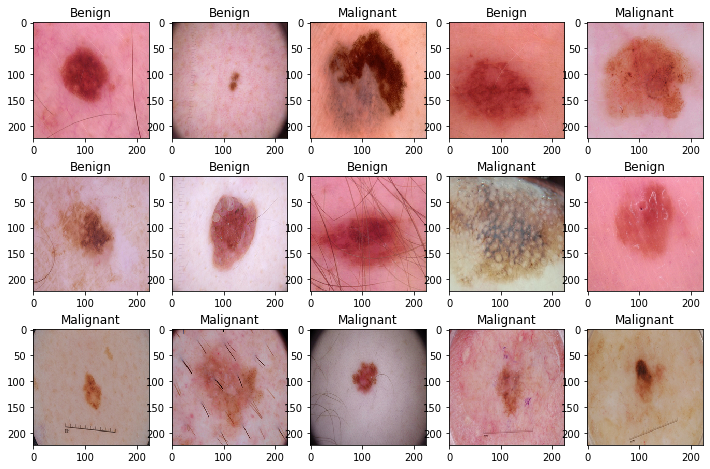

In [24]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [25]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

In [26]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [31]:
# See learning curve and validation curve
#lenet+BN layer+dropout
#https://zhuanlan.zhihu.com/p/61725100#:~:text=%E7%AC%AC%E4%B8%80%E4%B8%AA%E6%96%B9%E6%A1%88%E6%AF%94%E8%BE%83%E7%AE%80,%E9%80%83%E9%81%BF%E9%97%AE%E9%A2%98%E7%9A%84%E6%84%9F%E8%A7%89%E3%80%82
def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

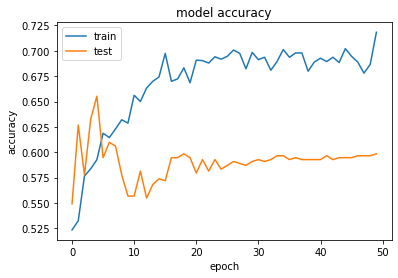

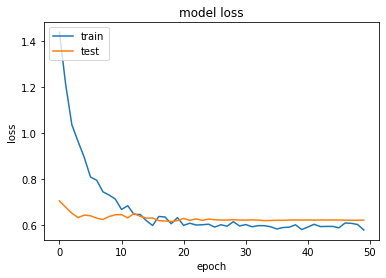

In [39]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [40]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()

Saved model to disk


In [43]:
#以下是检验的如果要用的话请重新运行上上个cell
K.clear_session()
del history

In [44]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(X_train, y_train):
  # create model
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [105]:
#load weighs
#input_shape = (224,224,3)
#lr = 1e-5
#init = 'normal'
#activ = 'relu'
#optim = 'adam'
#epochs = 50
#batch_size = 64

#model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)
from keras.models import model_from_json
model=model_from_json(open('model.json').read())
model.load_weights('model.h5')

In [109]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
test_image=[read('test.jpg')]
test=np.array(test_image, dtype='uint8')
#prediction
prediction = model.predict(test)
print(prediction)

[[1. 0.]]
